# 1. Setup and Imports

In [47]:
import sys
import os
import time
from matplotlib import pyplot as plt

# Add the src directory to the path so we can import malthusjax
sys.path.append('/Users/leonardodicaterina/Documents/GitHub/MalthusJAX/src')

import jax
import jax.numpy as jnp
import jax.random as jar


print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())

JAX version: 0.7.0
Available devices: [CpuDevice(id=0)]


# 1. BinaryGenome
The BinaryGenome class represents a binary string, which serves as the genetic material for our evolutionary algorithms.

## 1.1 Initialization
You can initialize a BinaryGenome by specifying custom ones like array_size and a probability p and either assigning a specific tensor or allowing manually or random initialization.

In [48]:
from malthusjax.core.genome import BinaryGenome
from malthusjax.core.population.base import AbstractPopulation
#
genome_init_params = {'array_size': 5, 'p': 0.5}
pop1 = AbstractPopulation(genome_cls=BinaryGenome,
                          pop_size=5,
                          random_key=jar.PRNGKey(42),
                          random_init=True,
                          genome_init_params=genome_init_params,
                          fitness_transform=None)

print(f"Population 1: \n{pop1}")

Population 1: 
Population(genome_cls=BinaryGenome, pop_size=5, current_size=5):
[False  True False False False]
[False False  True  True  True]
[False False  True  True  True]
[ True  True  True False  True]
[False False False False False]


In [49]:
array = jnp.array([1,1,0,0,3])
new_pop = pop1.from_array_of_indexes(array)
print(new_pop.get_genomes())

[[False False  True  True  True]
 [False False  True  True  True]
 [False  True False False False]
 [False  True False False False]
 [ True  True  True False  True]]


In [50]:
# Let's explore the population structure more thoroughly
print("=== Population Structure Analysis ===")
print(f"Population type: {type(pop1)}")
print(f"Solutions type: {type(pop1.get_genomes())}")
print(f"Solutions shape: {pop1.get_genomes().shape}")
print(f"Solutions dtype: {pop1.get_genomes().dtype}")
print(f"Population size: {pop1._pop_size}")

print("\n=== Individual Genome Analysis ===")
# Look at individual genomes
for i in range(min(3, pop1._pop_size)):  # Show first 3 genomes
    genome_data = pop1.get_genomes()[i]
    print(f"Genome {i}: {genome_data}")
    print(f"  - As integers: {genome_data.astype(jnp.int32)}")
    print(f"  - Sum (number of True bits): {jnp.sum(genome_data)}")

print("\n=== Population Statistics ===")
# Population-level statistics
total_ones = jnp.sum(pop1.get_genomes())
total_bits = pop1.get_genomes().size
print(f"Total bits in population: {total_bits}")
print(f"Total 1s (True values): {total_ones}")
print(f"Ratio of 1s: {total_ones / total_bits:.3f}")
print(f"Expected ratio (p=0.5): 0.500")

print("\n=== Access Individual Genomes ===")
# Show how to access individual genomes from the population
if hasattr(pop1, 'get_genome'):
    first_genome = pop1.get_genome(0)
    print(f"First genome object: {first_genome}")
    print(f"First genome tensor: {first_genome.to_tensor()}")
else:
    # If direct access method doesn't exist, show tensor access
    print("Direct tensor access:")
    print(f"First genome tensor: {pop1[0]}")
    print(f"Last genome tensor: {pop1[-1]}")

print("\n=== Vectorized Operations Example ===")
# Show the power of having solutions as a JAX array
# Calculate Hamming distances between all pairs


distance_matrix = pop1.get_distance_matrix_function_jit()(pop1.to_stack())
print(f"Distance matrix shape: {distance_matrix.shape}")
print("Pairwise Hamming distances:")
print(distance_matrix)

print(f"\nAverage distance between genomes: {jnp.mean(distance_matrix[jnp.triu_indices(10, k=1)]):.2f}")
print(f"Maximum distance: {jnp.max(distance_matrix)}")
# Create a mask for self-distances
mask = jnp.eye(pop1._pop_size, dtype=bool)*jnp.inf
distance_matrix = distance_matrix + mask
print(f"Minimum distance (excluding self): {jnp.min(distance_matrix)}")


=== Population Structure Analysis ===
Population type: <class 'malthusjax.core.population.base.AbstractPopulation'>
Solutions type: <class 'jaxlib._jax.ArrayImpl'>
Solutions shape: (5, 5)
Solutions dtype: bool
Population size: 5

=== Individual Genome Analysis ===
Genome 0: [False  True False False False]
  - As integers: [0 1 0 0 0]
  - Sum (number of True bits): 1
Genome 1: [False False  True  True  True]
  - As integers: [0 0 1 1 1]
  - Sum (number of True bits): 3
Genome 2: [False False  True  True  True]
  - As integers: [0 0 1 1 1]
  - Sum (number of True bits): 3

=== Population Statistics ===
Total bits in population: 25
Total 1s (True values): 11
Ratio of 1s: 0.440
Expected ratio (p=0.5): 0.500

=== Access Individual Genomes ===
Direct tensor access:
First genome tensor: [False  True False False False]
Last genome tensor: [False False False False False]

=== Vectorized Operations Example ===
Distance matrix shape: (5, 5)
Pairwise Hamming distances:
[[0 4 4 3 1]
 [4 0 0 3 3]
 [

you can transform a genome back to tensor


In [51]:
# you can transform a genome back to tensor
pop_from_genome = pop1.from_stack(pop1.to_stack())
print(f'Tensor from genome:\n\t{pop_from_genome}')

Tensor from genome:
	Population(genome_cls=BinaryGenome, pop_size=5, current_size=5):
[False  True False False False]
[False False  True  True  True]
[False False  True  True  True]
[ True  True  True False  True]
[False False False False False]


## 1.2 Validation
when creating creating a genome from tensor it will automaticlly clip to 0/1 ensuring all elements are binary, the only way to have an invalid genome is to manually assign a tensor with values other than 0 or 1, or assign a tensor of wrong size.

to efficently corect invalid genomes you can use .get_autovalidation_jit() that returns a jit compiled function that will correct the genome inplace, this will help later on when using genetic operators that might produce invalid genomes

In [52]:
auto_correction_function = BinaryGenome.get_autocorrection_jit(genome_init_params= genome_init_params)
invalid_stack  = jnp.array([[
    0, 2, 1, 0, 1],
    [0, -1, 1, 0, 1],
    [0, 1, 1, 0, 1], 
    [0, 1, 1, 0, 1],
    [0, 1, 1, 0, 3],
    [0, 1, 1, 0, -5]
], dtype=jnp.int32)
print("\n=== Invalid Genomes Before Auto-correction ===")


corrected_stack = jax.vmap(auto_correction_function)(invalid_stack)

print("\n=== Auto-correction of Invalid Genomes ===")
for i, (invalid, corrected) in enumerate(zip(invalid_stack, corrected_stack)):
    print(f"Genome {i} - Invalid: {invalid}, Corrected: {corrected}, Is valid now: {jnp.all((corrected == 0) | (corrected == 1))}")



=== Invalid Genomes Before Auto-correction ===

=== Auto-correction of Invalid Genomes ===
Genome 0 - Invalid: [0 2 1 0 1], Corrected: [0 1 1 0 1], Is valid now: True
Genome 1 - Invalid: [ 0 -1  1  0  1], Corrected: [0 0 1 0 1], Is valid now: True
Genome 2 - Invalid: [0 1 1 0 1], Corrected: [0 1 1 0 1], Is valid now: True
Genome 3 - Invalid: [0 1 1 0 1], Corrected: [0 1 1 0 1], Is valid now: True
Genome 4 - Invalid: [0 1 1 0 3], Corrected: [0 1 1 0 1], Is valid now: True
Genome 5 - Invalid: [ 0  1  1  0 -5], Corrected: [0 1 1 0 0], Is valid now: True


In [53]:
indexes = jar.choice(jar.PRNGKey(2), a=pop1._pop_size, shape=(pop1._pop_size,), replace=False)
print(f"Randomly selected indexes: {indexes}")

selection_fn = pop1.get_from_array_of_indexes_jit()

selected_population = selection_fn(pop1.to_stack(), indexes)
print(f"Selected population: \n{selected_population}")
# you can transform a genome back to tensor

Randomly selected indexes: [2 4 1 3 0]
Selected population: 
[[False False  True  True  True]
 [False False False False False]
 [False False  True  True  True]
 [ True  True  True False  True]
 [False  True False False False]]


## 1.3 Testing dunder methods

In [54]:
print(f"Population length (should be {pop1._pop_size}): {len(pop1)}")
print(f"First genome via pop1[0]: {pop1[0]}")
print(f"Last genome via pop1[-1]: {pop1[-1]}")
# iterate over the population
print("Iterating over population:")
for i, genome in enumerate(pop1):
    print(f"Genome {i}: {genome}")

Population length (should be 5): 5
First genome via pop1[0]: [False  True False False False]
Last genome via pop1[-1]: [False False False False False]
Iterating over population:
Genome 0: [False  True False False False]
Genome 1: [False False  True  True  True]
Genome 2: [False False  True  True  True]
Genome 3: [ True  True  True False  True]
Genome 4: [False False False False False]


## 1.4 Sorting

In [55]:
random_fitness_values = jar.uniform(jar.PRNGKey(3), shape=(pop1._pop_size,))
sortfn = pop1.get_sort_by_fitness_jit()

sorted_population = sortfn(pop1.to_stack(), random_fitness_values)
for i, (genome, fitness) in enumerate(zip(sorted_population[0], sorted_population[1])):
    print(f"Sorted Genome {i}: {genome} - Fitness: {fitness:.4f}")

Sorted Genome 0: [ True  True  True False  True] - Fitness: 0.9756
Sorted Genome 1: [False False  True  True  True] - Fitness: 0.9381
Sorted Genome 2: [False False  True  True  True] - Fitness: 0.6490
Sorted Genome 3: [False False False False False] - Fitness: 0.2784
Sorted Genome 4: [False  True False False False] - Fitness: 0.0741


## 1.5 Distance Calculation (Hamming Distance)
The framework supports calculating the Hamming distance between two binary genomes, representing the number of positions at which the corresponding bits are different.

In [56]:
distance_fn = pop1.get_distance_matrix_function_jit()

# Time the JIT version
start = time.time()
print(f"JIT Distance between genome1 and genome2: \n{distance_fn(pop1.to_stack())[0,1]}")
jit_time = time.time() - start

JIT Distance between genome1 and genome2: 
4


In [57]:
single_distance_fn = pop1._genome_cls.get_distance_jit()
single_distance_fn(pop1[0], pop1[1])

Array(4, dtype=int32)

In [58]:
single_distance_fn = pop1._genome_cls.get_distance_jit()
# Time the regular version
start = time.time()
for i in range(pop1._pop_size):
    for j in range(pop1._pop_size):
        dist = single_distance_fn(pop1[i], pop1[j])
        # Uncomment below to see individual distances
        # print(f"Distance between genome {i} and genome {j}: {dist}")
regular_time = time.time() - start

print(f"\nTiming comparison:")
print(f"JIT version: {jit_time:.6f} seconds")
print(f"Regular version: {regular_time:.6f} seconds")


Timing comparison:
JIT version: 0.084821 seconds
Regular version: 0.015927 seconds


# Tries with different Genome types

Categorical Population solutions before autocorrection:
Population(genome_cls=CategoricalGenome, pop_size=10, current_size=10):
[1 2 1 0 0]
[10  1  1  1  2]
[3 0 3 0 0]
[1 2 0 3 1]
[2 3 3 2 1]
[3 0 0 1 0]
[1 1 0 0 1]
[3 1 2 0 2]
[3 3 1 0 2]
[0 0 3 2 0]
Genome: [1 2 1 0 0]
Genome: [10  1  1  1  2]
Genome: [3 0 3 0 0]
Genome: [1 2 0 3 1]
Genome: [2 3 3 2 1]
Genome: [3 0 0 1 0]
Genome: [1 1 0 0 1]
Genome: [3 1 2 0 2]
Genome: [3 3 1 0 2]
Genome: [0 0 3 2 0]
corrected Categorical genome solutions:
[3 1 1 1 2]


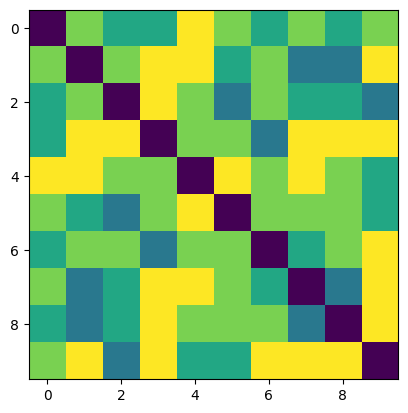

In [59]:
from malthusjax.core.genome.categorical import CategoricalGenome

pop2 = AbstractPopulation(genome_cls=CategoricalGenome,
                                 pop_size=10,
                                 random_key=jar.PRNGKey(123),
                                 random_init=True,
                                 genome_init_params={'array_size': 5, 'num_categories': 4})


    
pop2._genomes = pop2._genomes.at[1, 0].set(10) 
print(f"Categorical Population solutions before autocorrection:\n{pop2}")
for genome in pop2:
    print(f"Genome: {genome}")

auto_correction_function_cat = pop2.get_autocorrection_function_jit()
pop2._genomes = auto_correction_function_cat(pop2._genomes)
print(f"corrected Categorical genome solutions:\n{pop2[1]}")

distance_fn = pop2.get_distance_matrix_function_jit()
plt.imshow(distance_fn(pop2._genomes), cmap='viridis')

Permutation Population solutions before autocorrection:
Population(genome_cls=PermutationGenome, pop_size=10, current_size=10):
[0 1]
[10  1]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
Genome: [0 1]
Genome: [10  1]
Genome: [0 1]
Genome: [1 0]
Genome: [1 0]
Genome: [0 1]
Genome: [0 1]
Genome: [1 0]
Genome: [0 1]
Genome: [0 1]
corrected Permutation genome solutions:
[10  1]


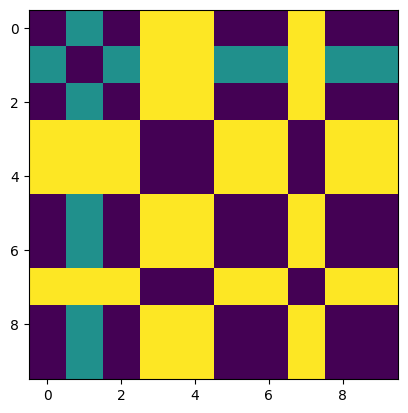

In [61]:
from matplotlib import pyplot as plt
from malthusjax.core.genome.permutation import PermutationGenome
pop2 = AbstractPopulation(genome_cls=PermutationGenome,
                                 pop_size=10,
                                 random_key=jar.PRNGKey(123),
                                 random_init=True,
                                 genome_init_params={'array_size': 5})


    
pop2._genomes = pop2._genomes.at[1, 0].set(10) 
print(f"Permutation Population solutions before autocorrection:\n{pop2}")
for genome in pop2:
    print(f"Genome: {genome}")

auto_correction_function_perm = pop2.get_autocorrection_function_jit()
pop2._genomes = auto_correction_function_perm(pop2._genomes)
print(f"corrected Permutation genome solutions:\n{pop2[1]}")

distance_fn = pop2.get_distance_matrix_function_jit()
plt.imshow(distance_fn(pop2._genomes), cmap='viridis')